# Capstone Project: Udacity Machine Learning Engineer
## Hans Fricke 2018
## Approval prediction

In [1]:
# import packages
import pandas as pd
import os
import numpy as np
import pprint
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# display formatting 
%matplotlib inline 
pd.options.display.float_format = '{:20,.2f}'.format

# change working directory
os.chdir("/Users/hansfricke/Dropbox/ND ML Engineer/Capstone")

In [3]:
data = pd.read_pickle('Data/final_data.pkl')

### Splitting data in training and testing samples

In [4]:
# get a list of all column names in the data set
x_cols = list(data.columns)

In [5]:
# only keep feature names by removing id and approval status
x_cols.remove('id')
x_cols.remove('approved')

In [6]:
# split the data into training and test data set
X_train, X_test, y_train, y_test = train_test_split(data[x_cols], data['approved'], test_size=0.25, random_state=42)

### Define three different sets features used to predict approval
1. All meta data
2. All meta data + NMF topic loadings
3. All meta data + PCA components

This allows me to understand which of the dimansionality reduction techniques was more suited for this classification problem.

In [7]:
# no text information
X_train1 = X_train.loc[:,:'num_items']
X_test1 = X_test.loc[:,:'num_items']
# nmf topics
X_train2 = X_train.loc[:,:'c_total_descriptionTopic1']
X_test2 = X_test.loc[:,:'c_total_descriptionTopic1']
# pca components
X_train3 = X_train.drop([ 'c_essay1Topic0',
                         'c_essay1Topic1',
                         'c_essay2Topic0',
                         'c_essay2Topic1',
                         'c_resource_summaryTopic0',
                         'c_resource_summaryTopic1',
                         'c_resource_summaryTopic2',
                         'c_total_descriptionTopic0',
                         'c_total_descriptionTopic1'], axis=1)
X_test3 = X_test.drop([ 'c_essay1Topic0',
                         'c_essay1Topic1',
                         'c_essay2Topic0',
                         'c_essay2Topic1',
                         'c_resource_summaryTopic0',
                         'c_resource_summaryTopic1',
                         'c_resource_summaryTopic2',
                         'c_total_descriptionTopic0',
                         'c_total_descriptionTopic1'], axis=1)

In [8]:
datasets = {'NoText': {'X_train': X_train1,
                        'X_test': X_test1},
            'withNMF': {'X_train': X_train2,
                        'X_test': X_test2},
            'withPCA': {'X_train': X_train3,
                        'X_test': X_test3}}

### Scale features to have mean zero and standard deviation one

In [9]:
def scale(train, test):
    scaler = StandardScaler()
    scaler.fit(train)  
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [10]:
for dataset in datasets.values():
    dataset['X_train'], dataset['X_test'] = scale(dataset['X_train'], dataset['X_test'])

### Functions to implement the classification and evaluation

#### Function to train model with grid search

In [11]:
def train_model(classifier, parameters, X, y, scorer=None):
    clf = GridSearchCV(classifier, parameters, scoring=scorer)
    clf.fit(X, y)
    return clf

#### Function to calculate accuracy, f1-score, and the area under ROC curve

In [12]:
def get_metrics(trained_classifier, X_test, y_test):
    pred = trained_classifier.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, pred)
    return acc, f1, roc

#### Fuction to return the best parameter combination

In [13]:
def get_best_parametres(gridsearch_obj):
    return gridsearch_obj.best_params_

#### Function to fit all specifed algoritms and features sets

In [14]:
# algorithms has to be a dictionary that contains the algorithm classes and the parameter grids
def fit_all_models(algorithms, scorer = None):
    fitted_algorithms = {}
    # iterates over the dictionary with each algorithm
    for algo_name, algorithm in algorithms.items():
        print('****', algo_name, '****')
        sets = {}
        start = time.time()
        # iterates over feature sets
        for set_name, dataset in datasets.items():
            # uses grid search to fit the algorithm
            sets[set_name] = train_model(algorithm['classifier'],
                                         algorithm['params'],
                                         dataset['X_train'],
                                         y_train, 
                                         scorer=scorer)
            end = time.time()
            print("{0}: {1:.2f} minutes".format(set_name, (end - start)/60))
        fitted_algorithms[algo_name] = sets
    # returns fitted gridsearch object    
    return fitted_algorithms

#### Function that returns the best parameter combination for each algorithm and feature set

In [15]:
def get_all_parameters(fitted):
    best_parameters = {}
    for algo_name, algorithm in fitted.items():
        sets = {}
        for set_name, dataset in datasets.items():
            sets[set_name] = get_best_parametres(algorithm[set_name])
        best_parameters[algo_name] = sets    
    return best_parameters

#### Function that returns the all three scores for each algorithm (with best parameters) and feature set

In [16]:
def get_all_scores(fitted):
    scores = {}
    for algo_name, algorithm in fitted.items():
        sets = {}
        for set_name, dataset in datasets.items():
            sets[set_name] = [*get_metrics(algorithm[set_name], dataset['X_test'], y_test)]
        scores[algo_name] = sets    
    return scores

#### Function that creates a dataframe with the score suitable for seaborn's factorplot 

In [17]:
def reshape_data(scores):
    stacked_scores = []
    stacked_datasets = []
    stacked_models = []
    for model_name, model in scores.items():
        for set_name, dataset in model.items():
            stacked_scores.extend([*dataset])
            stacked_datasets.extend(3*[set_name])
            stacked_models.extend(3*[model_name])
    data = {'Metric': 9*['Accuracy', 'F1', 'ROC'],
            'Score': stacked_scores,
            'Dataset': stacked_datasets,
            'Model': stacked_models}
    return pd.DataFrame(data)

#### Function that plots the resuts with seaborn's factorplot

In [18]:
def performance_plot(scores, path, name):
    graph_data = reshape_data(scores)
    g = sns.factorplot(x='Model', 
                   y='Score', 
                   hue='Dataset', 
                   data=graph_data, 
                   kind='bar', 
                   palette="BuGn_d", 
                   col='Metric')
    g.fig.suptitle(name, y=1.05)
    save_as = path + "/" + name + ".png"
    plt.savefig(save_as)
    plt.show()

### First iteration

#### Specify algorithms and parameters for grid search

In [21]:
algorithms = {'Logit': {'classifier': LogisticRegression(random_state=879),
                       'params': {}},
              'Random Forrest': {'classifier': RandomForestClassifier(random_state=98798, n_jobs=-1),
                                'params': {'max_depth': range(1,22,2),
                                            'min_impurity_decrease': [i/10000 for i in range(0,10)]}},
              'SGD':{'classifier': SGDClassifier(random_state=67876, n_jobs=-1, max_iter=50),
                    'params': {'alpha': [i/10000 for i in range(1,10)],
                                'tol': [i/100 for i in range(1,10)]}}
}

#### Use the area under the ROC curve for validation

In [22]:
roc_scorer = make_scorer(roc_auc_score)

#### Cross-validate the models

In [21]:
fitted = fit_all_models(algorithms, scorer=roc_scorer)

**** Logit ****
NoText: 0.25 minutes
withNMF: 0.53 minutes
withPCA: 1.06 minutes
**** Random Forrest ****
NoText: 4.55 minutes
withNMF: 9.54 minutes
withPCA: 18.79 minutes
**** SGD ****
NoText: 1.42 minutes
withNMF: 2.86 minutes
withPCA: 5.86 minutes


#### Show parameters

In [22]:
pprint.pprint(get_all_parameters(fitted), indent=3)

{  'Logit': {'NoText': {}, 'withNMF': {}, 'withPCA': {}},
   'Random Forrest': {  'NoText': {  'max_depth': 21,
                                     'min_impurity_decrease': 0.0},
                        'withNMF': {  'max_depth': 21,
                                      'min_impurity_decrease': 0.0},
                        'withPCA': {  'max_depth': 21,
                                      'min_impurity_decrease': 0.0}},
   'SGD': {  'NoText': {'alpha': 0.0001, 'tol': 0.05},
             'withNMF': {'alpha': 0.0001, 'tol': 0.07},
             'withPCA': {'alpha': 0.0001, 'tol': 0.09}}}


### Second iteration

#### Adjust parameters

In [23]:
algorithms2 = {'Logit': {'classifier': LogisticRegression(random_state=879),
                       'params': {}},
              'Random Forrest': {'classifier': RandomForestClassifier(random_state=98798, n_jobs=-1),
                                 # adjust max depth
                                'params': {'max_depth': range(1,62,5),
                                           # Adjust min_impurity
                                            'min_impurity_decrease': [i/1000000 for i in range(0,100,10)]}},
              'SGD':{'classifier': SGDClassifier(random_state=67876, n_jobs=-1, max_iter=50),
                    'params': {# Adjust alpha
                                'alpha': [i/100000 for i in range(1,10)],
                                'tol': [i/100 for i in range(1,10)]}}
}

#### Cross-validate models

In [24]:
fitted2 = fit_all_models(algorithms2, scorer=roc_scorer)

**** Logit ****
NoText: 0.20 minutes
withNMF: 0.46 minutes
withPCA: 0.89 minutes
**** Random Forrest ****
NoText: 6.22 minutes
withNMF: 13.82 minutes
withPCA: 31.61 minutes
**** SGD ****
NoText: 2.05 minutes
withNMF: 4.28 minutes
withPCA: 9.03 minutes


#### Show parameters

In [25]:
pprint.pprint(get_all_parameters(fitted2), indent=3)

{  'Logit': {'NoText': {}, 'withNMF': {}, 'withPCA': {}},
   'Random Forrest': {  'NoText': {  'max_depth': 56,
                                     'min_impurity_decrease': 0.0},
                        'withNMF': {  'max_depth': 56,
                                      'min_impurity_decrease': 0.0},
                        'withPCA': {  'max_depth': 56,
                                      'min_impurity_decrease': 0.0}},
   'SGD': {  'NoText': {'alpha': 2e-05, 'tol': 0.07},
             'withNMF': {'alpha': 1e-05, 'tol': 0.04},
             'withPCA': {'alpha': 4e-05, 'tol': 0.06}}}


### Third iteration

#### Adjust parameter grid

In [23]:
algorithms3 = {'Logit': {'classifier': LogisticRegression(random_state=879),
                       'params': {}},
              'Random Forrest': {'classifier': RandomForestClassifier(random_state=98798, n_jobs=-1),
                                'params': {'max_depth': range(1,62,5),
                                           # Adjust min_impurity
                                            'min_impurity_decrease': [i/10000000 for i in range(0,100,10)]}},
              'SGD':{'classifier': SGDClassifier(random_state=67876, n_jobs=-1, max_iter=50),
                    'params': { 'alpha': [i/100000 for i in range(1,10)],
                                'tol': [i/100 for i in range(1,10)]}}
}

#### Cross validation

In [24]:
fitted3 = fit_all_models(algorithms3, scorer=roc_scorer)

**** Logit ****
NoText: 0.24 minutes
withNMF: 0.53 minutes
withPCA: 0.99 minutes
**** Random Forrest ****
NoText: 9.28 minutes
withNMF: 20.33 minutes
withPCA: 43.55 minutes
**** SGD ****
NoText: 2.06 minutes
withNMF: 4.21 minutes
withPCA: 8.35 minutes


#### Show parameters

In [25]:
pprint.pprint(get_all_parameters(fitted3), indent=3)

{  'Logit': {'NoText': {}, 'withNMF': {}, 'withPCA': {}},
   'Random Forrest': {  'NoText': {  'max_depth': 56,
                                     'min_impurity_decrease': 0.0},
                        'withNMF': {  'max_depth': 56,
                                      'min_impurity_decrease': 0.0},
                        'withPCA': {  'max_depth': 56,
                                      'min_impurity_decrease': 0.0}},
   'SGD': {  'NoText': {'alpha': 2e-05, 'tol': 0.07},
             'withNMF': {'alpha': 1e-05, 'tol': 0.04},
             'withPCA': {'alpha': 4e-05, 'tol': 0.06}}}


### Evaluate models on test sample

#### Calculate scores for test sample

In [26]:
scores3 = get_all_scores(fitted3)

#### Plot and show scores

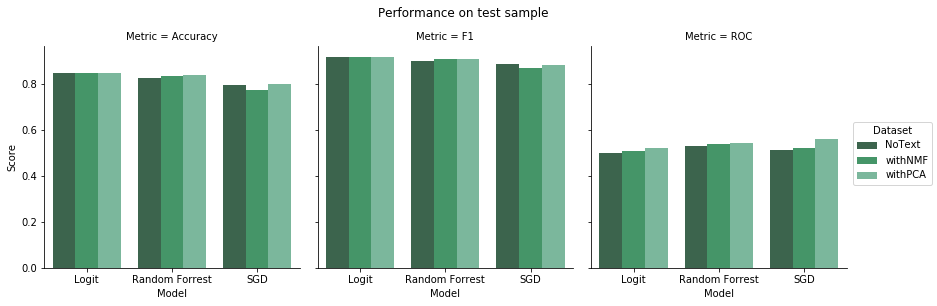

In [27]:
performance_plot(scores3, './Graphs', 'Performance on test sample')

In [28]:
pprint.pprint(scores3)

{'Logit': {'NoText': [0.84648506151142355,
                      0.91679367498571152,
                      0.50143716539210637],
           'withNMF': [0.8475395430579965,
                       0.91719760421886565,
                       0.50849502066182839],
           'withPCA': [0.84870386643233742,
                       0.91746857286660988,
                       0.5215810443971276]},
 'Random Forrest': {'NoText': [0.82409929701230233,
                               0.90180881721748729,
                               0.53015013035492087],
                    'withNMF': [0.83488576449912122,
                                0.90834369893417233,
                                0.53751792499622508],
                    'withPCA': [0.83697275922671355,
                                0.90937954109731223,
                                0.54483070823625201]},
 'SGD': {'NoText': [0.79721001757469245,
                    0.88506219416532816,
                    0.51452151668523882],
   

#### Look at confusion matrix for logit and SDG to understand why accuracy is lower but area under ROC is higher

In [29]:
def get_confusion_matrix(trained_classifier, X_test, y_test, path, name):
    pred = trained_classifier.predict(X_test)
    confusion = confusion_matrix(y_test, pred)
    ax = sns.heatmap(confusion)
    save_as = path + "/" + name + ".png"
    plt.savefig(save_as)
    plt.show()
    return confusion.ravel()   

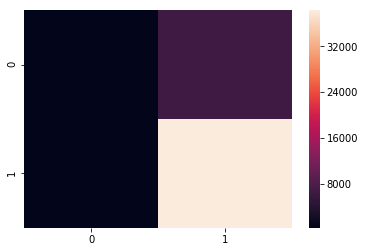

353 6591 296 38280


In [30]:
# logit
tn, fp, fn, tp = get_confusion_matrix(fitted3['Logit']['withPCA'], 
                                      datasets['withPCA']['X_test'], 
                                      y_test,
                                      './Graphs', 
                                      'Confusion matrix logit')
print(tn, fp, fn, tp)

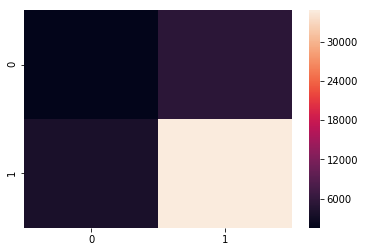

1530 5414 3792 34784


In [31]:
# SGD
tn, fp, fn, tp = get_confusion_matrix(fitted3['SGD']['withPCA'], 
                                      datasets['withPCA']['X_test'], 
                                      y_test,
                                      './Graphs', 
                                      'Confusion matrix SGD')
print(tn, fp, fn, tp)